# Predicting Site Use by PFAS Composition
## Exploratory Data Analysis 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl

## Project Goal

The goal of this project is to investigate PFAS data from the state of California and use the ratios of different PFAS chemicals in each sample to predict the site use for the site where that sample was taken. The data was downloaded here.
https://geotracker.waterboards.ca.gov/map/pfas_map

First some definitions.

PFAS:  Per- and Polyfluorinated Substances. A family of chemicals found in a wide variety of products. If you have heard of ‘forever chemicals’ that’s what these are.

Non Detect: When a lab runs a test for a particular chemical they calculate a limit called the detection limit, where if the chemical is present in contractions equal to or greater than that limit they will detect it. If they don't detect it, they say it's less than the detect limit because they don’t know if there is any of that chemical below that limit. It is essentially the sensitivity limit of the instrument the lab is using. 

Matrix: This is the type of sample taken, i.e. are they testing soil, water or air.

Site Use: What the site was being used for, is it a waste water treatment plant, an oil refinery, ect...

In [2]:
# read in the data
df = pd.read_csv('/Users/benkupernk/Documents/GitHub/ML2 Final/ALL_PFAS_CHEMICALS.csv')
print(df.columns)
df

Index(['Regional Board', 'Public Water System Name', 'Site Name', 'Global ID',
       'Location ID', 'Sample ID', 'Matrix', 'Chemical Name',
       'Chemical Abbreviation', 'Qualifier', 'Value', 'Reporting Limit',
       'Detection Limit', 'Analytical Method Code', 'Lab Notes', 'QRAA',
       'Units', 'Date', 'Treated Drinking Water Sample ID',
       'Treated Drinking Water Qualifier', 'Treated Drinking Water Value',
       'Treated Drinking Water Reporting Limit',
       'Treated Drinking Water Units', 'Treated Drinking Water Date',
       'Field Pt Class', 'Site Use', 'Site Type', 'Facility Type', 'Status',
       'Address', 'City', 'Latitude', 'Longitude'],
      dtype='object')


,Regional Board,Public Water System Name,Site Name,Global ID,Location ID,Sample ID,Matrix,Chemical Name,Chemical Abbreviation,Qualifier,...,Treated Drinking Water Date,Field Pt Class,Site Use,Site Type,Facility Type,Status,Address,City,Latitude,Longitude
0,LAHONTAN RWQCB (REGION 6T),"TRUCKEE-DONNER PUD, MAIN",Tahoe Truckee Sanitation Agency,WDR100034937,EFFLUENT,Final Effluent,Liquid,11-Chloroeicosafluoro-3-oxaundecane-1-sulfonic...,11ClPF3OUDS,ND,...,NaN,ES,Wastewater Treatment Plants,WDR Site,NaN,Active - WDR,13720 Butterfield Drive,Truckee,39.339044,-120.127773
1,SAN FRANCISCO BAY RWQCB (REGION 2),SAN JOSE WATER,San Jose Intl Airport,T10000012766,L4-3,L4-3-10,Solid,"6:2 Fluorotelomer sulfonic acid (1H,1H,2H,2H-P...",6:2FTS,ND,...,NaN,BH,Airport,Cleanup Program Site,NaN,Open - Site Assessment,1701 Airport Blvd,San Jose,37.359332,-121.931214
2,LOS ANGELES RWQCB (REGION 4),CAL AMERICAN WATER CO,Hill Canyon WWTP,NPD100051993,HCTP INF,Influent,Liquid,"8:2 Fluorotelomer sulfonic acid (1H, 1H, 2H, 2...",8:2FTS,=,...,NaN,IS,Wastewater Treatment Plants,NPDES,NaN,Active,9600 Santa Rosa Road,Camarillo,34.210560,-118.920000
3,LOS ANGELES RWQCB (REGION 4),LONG BEACH UTILITIES DEPARTMENT,LONG BEACH / DAUGHERTY FIELD,T10000012772,TJB-1,TJB-1-25,Solid,N-Ethyl perfluorooctane sulfonamidoacetic acid,NETFOSAA,ND,...,NaN,BH,Airport,Cleanup Program Site,NaN,Open - Site Assessment,4100 Donald Douglas DR,Long Beach,33.816256,-118.156471
4,CENTRAL VALLEY RWQCB (REGION 5F),WEST KERN WATER DISTRICT,California Resources Corporation - Elk Hills O...,T10000016467,B12,B12-3,Solid,N-Ethyl perfluorooctane sulfonamide,ETFOSA,<,...,NaN,BH,Industrial - Bulk Fuel Terminal/Refinery,Cleanup Program Site,NaN,Open - Site Assessment,28590 Hwy 119,Tupman,35.277154,-119.472638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886364,NaN,"DOWNEY - CITY, WATER DEPT.",WELL 04,W0601910034,CA1910034_032_032,NaN,Liquid,Perfluorooctanoic sulfonate,PFOS,=,...,NaN,PUBW,Drinking Water Wells,DDW Well,NaN,NaN,NaN,DOWNEY,33.963401,-118.121959
886365,NaN,HOOD WATER MAINTENCE DIST [SWS],WELL W-25,W0603400101,CA3400101_003_003,NaN,Liquid,Perfluorobutanoic acid,PFBA,<,...,NaN,PUBW,Drinking Water Wells,DDW Well,NaN,NaN,NaN,HOOD,38.366202,-121.511872
886366,NaN,"BAKERSFIELD, CITY OF",WELL CBK 01-02 - RAW,W0601510031,CA1510031_043_043,NaN,Liquid,Perfluorooctanoic sulfonate,PFOS,<,...,NaN,PUBW,Drinking Water Wells,DDW Well,NaN,NaN,NaN,BAKERSFIELD,35.339947,-119.075068
886367,NaN,CWS - BAKERSFIELD,WELL 146-01 - BEFORE_GAC-TCP,W0601510003,CA1510003_111_111,NaN,Liquid,Perfluorooctanoic sulfonate,PFOS,=,...,NaN,PUBW,Drinking Water Wells,DDW Well,NaN,NaN,NaN,BAKERSFIELD,35.309807,-119.048817


In [3]:
# what units are they using
df.Units.unique()

array(['NG/L', 'UG/KG', 'NG/KG', 'UG/M3'], dtype=object)

In [4]:
# what type of samples are there?
df.Matrix.value_counts()

Matrix
Liquid    731468
Solid     154867
Gas           34
Name: count, dtype: int64

# Sampling results
In this data set they have tested mostly groundwater but have also included a large set of soil samples and a very small amount of air samples. Due to cost constraints and groundwater sampling is done much more routinely than soil sampling. Soil sampling is typically only done when there is a contaminated site and thus should have much more interesting results, so I’ll only be looking at soil samples in this analysis. Since I’ll be converting the sample results to percent of total for each sample the units will cancle out.

To address non detects in the data I’ll substitute the detection limit in for the value of that analyte. I’ll filter out the lowest 5 percent of that data to eliminate any samples that are largely non detect (and would not show any interesting trends).

In [5]:
def get_val(row):
    """Replace any non detects in the value column with the detection limit"""
    val = row['Value']
    if val == 0:
        val = row['Detection Limit']
    return val

# The source data is putting 0 in the value column to represent a non detect. Replace it with the detection limit.
df.Value = df.apply(lambda row: get_val(row), axis = 1)

# Filter for only solid samples
df = df[df.Matrix == 'Solid']

# filter out any results that are likely to be uninformative
df = df[df.Value > df.Value.quantile(.5)]

# drop any duplicate results
df = df.drop_duplicates(subset = ['Site Name',  'Date', 'Units', 'Sample ID', 'Location ID', 'Chemical Abbreviation'])

# pivot the data from long to wide format
idx_columns = ['Site Name', 'Site Use', 'Date', 'Units', 'Sample ID', 'Location ID',  'Latitude', 'Longitude']
len_idx = len(idx_columns)
dfp = df.pivot(index = idx_columns, columns='Chemical Abbreviation', values=['Value'])

# fix the column names
dfp = dfp.reset_index(level = ['Site Name', 'Site Use', 'Date', 'Units', 'Sample ID', 'Location ID', 'Latitude', 'Longitude'])
dfp.columns = list(dfp.columns.get_level_values(0)[:len_idx ]) + list(dfp.columns.get_level_values(1)[len_idx :])

# lets see the transformed data
dfp

,Site Name,Site Use,Date,Units,Sample ID,Location ID,Latitude,Longitude,10:2FTS,11ClPF3OUDS,...,PFNS,PFOA,PFODA,PFOS,PFOSA,PFPA,PFPES,PFTEDA,PFTRIDA,PFUNDCA
0,4-S Ranch WRF,Wastewater Treatment Plants,03/03/2021,UG/KG,BFP Cake,BFP CAKE,33.014402,-117.112003,16.0,6.300,...,17.0,6.600,9.4,18.00,21.000,6.500,13.000,21.000,7.200,6.500
1,4-S Ranch WRF,Wastewater Treatment Plants,11/10/2020,UG/KG,BFP Cake,BFP CAKE,33.014402,-117.112003,10.0,4.000,...,11.0,4.300,6.1,11.00,14.000,4.200,8.200,13.000,4.600,4.200
2,A.K. Warren Water Resource Facility,Wastewater Treatment Plants,01/06/2021,UG/KG,21010600414,JW_BS_CAKE,33.805270,-118.280636,NaN,0.996,...,NaN,0.598,NaN,14.00,1.490,0.498,0.996,0.498,0.498,0.498
3,A.K. Warren Water Resource Facility,Wastewater Treatment Plants,04/07/2021,UG/KG,21040700441,JW_BS_CAKE,33.805270,-118.280636,NaN,2.950,...,NaN,0.983,NaN,14.70,0.983,0.983,0.983,1.970,1.970,0.983
4,A.K. Warren Water Resource Facility,Wastewater Treatment Plants,07/06/2021,UG/KG,21070600411,JW_BS_CAKE,33.805270,-118.280636,NaN,2.950,...,NaN,1.170,NaN,6.56,0.984,0.984,0.984,1.970,1.970,0.984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4677,Yreka City WWTP,Wastewater Treatment Plants,10/20/2021,UG/KG,21J0884-01 Biosolids,BIOSOLIDS,41.744100,-122.630730,17.0,6.800,...,18.0,7.200,10.0,19.00,23.000,10.000,14.000,22.000,7.700,7.000
4678,Yuba City WWTF,Wastewater Treatment Plants,03/18/2021,UG/KG,202103190266,BIO-001,39.108603,-121.612298,NaN,1.900,...,NaN,1.900,NaN,4.00,1.900,1.900,9.600,1.900,1.900,1.900
4679,Yuba City WWTF,Wastewater Treatment Plants,05/18/2021,UG/KG,202105190414,BIO-001,39.108603,-121.612298,NaN,1.700,...,NaN,1.700,NaN,3.30,1.700,1.700,8.500,1.700,1.700,1.700
4680,Yuba City WWTF,Wastewater Treatment Plants,08/25/2021,UG/KG,202108260557,BIO-001,39.108603,-121.612298,NaN,0.630,...,NaN,0.730,NaN,3.30,0.720,0.630,0.630,0.630,0.630,0.630


In [6]:
# look at how many values there are for each analyte.
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4682 entries, 0 to 4681
Data columns (total 52 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Site Name    4682 non-null   object 
 1   Site Use     4682 non-null   object 
 2   Date         4682 non-null   object 
 3   Units        4682 non-null   object 
 4   Sample ID    4682 non-null   object 
 5   Location ID  4682 non-null   object 
 6   Latitude     4677 non-null   float64
 7   Longitude    4677 non-null   float64
 8   10:2FTS      462 non-null    float64
 9   11ClPF3OUDS  1222 non-null   float64
 10  3:3FTCA      345 non-null    float64
 11  4:2FTS       3043 non-null   float64
 12  5:3FTCA      349 non-null    float64
 13  6:2FTS       3340 non-null   float64
 14  7:3FTCA      366 non-null    float64
 15  8:2FTS       3106 non-null   float64
 16  9ClPF3ONS    1254 non-null   float64
 17  ADONA        1151 non-null   float64
 18  ETFOSA       1426 non-null   float64
 19  ETFOSE

Since every sample did not test for every analyte I’ll have to find a combination of analytes that most samples were tested for. This is a balance between preserving features and preserving row count. I found the best balance was given by getting all columns where at least 25% of the rows had data in them and then filtering all the rows for non detect values. That gives me 884 samples with 29 features each.

In [7]:
# find which columns should be dropped
drop_list =[]
drop_limit = dfp.shape[0] * .25
for col in dfp.columns[len_idx:]:
    count = dfp[col].notna().sum()
    if count < drop_limit:
        drop_list.append(col)

# drop them
dfp_clean = dfp.drop(columns = drop_list)

# drop any rows where the analyte column have a nan value
dfp_clean = dfp_clean.dropna(subset = dfp_clean.columns[len_idx:], how = 'any').reset_index(drop = True)
dfp_clean.shape

(884, 37)

Now let’s convert the results to percent of total PFAS per sample so I can look at the ratios of PFAS rather than the magnitude.

In [8]:
# convert all values to precent of the total value for that row
dfp_clean[dfp_clean.columns[len_idx:]] =  dfp_clean[dfp_clean.columns[len_idx:]].div(dfp_clean[dfp_clean.columns[len_idx:]].sum(axis = 1), axis = 0)
print(dfp_clean['Site Use'].value_counts())

Site Use
Airport                                     291
Wastewater Treatment Plants                 286
Industrial - Bulk Fuel Terminal/Refinery    236
Industrial - Chrome Plating                  25
NPDES                                        21
Cleanup Program Site                         20
WDR Site                                      4
Land Disposal Site                            1
Name: count, dtype: int64


Since I’ll be comparing site use I’ll need a balanced dataset. The top three uses will give me that so let's filter for those.

In [9]:
uses = ['Airport', 'Wastewater Treatment Plants', 'Industrial - Bulk Fuel Terminal/Refinery']
dfp_clean = dfp_clean[dfp_clean['Site Use'].isin(uses)].reset_index(drop = True)
dfp_clean

,Site Name,Site Use,Date,Units,Sample ID,Location ID,Latitude,Longitude,11ClPF3OUDS,4:2FTS,...,PFNA,PFNDCA,PFOA,PFOS,PFOSA,PFPA,PFPES,PFTEDA,PFTRIDA,PFUNDCA
0,4-S Ranch WRF,Wastewater Treatment Plants,03/03/2021,UG/KG,BFP Cake,BFP CAKE,33.014402,-117.112003,0.019843,0.023307,...,0.011969,0.007874,0.020787,0.056693,0.066142,0.020472,0.040945,0.066142,0.022677,0.020472
1,4-S Ranch WRF,Wastewater Treatment Plants,11/10/2020,UG/KG,BFP Cake,BFP CAKE,33.014402,-117.112003,0.019704,0.023153,...,0.012315,0.007882,0.021182,0.054187,0.068966,0.020690,0.040394,0.064039,0.022660,0.020690
2,A.K. Warren Water Resource Facility,Wastewater Treatment Plants,01/06/2021,UG/KG,21010600414,JW_BS_CAKE,33.805270,-118.280636,0.011955,0.005978,...,0.005978,0.034209,0.007178,0.168043,0.017885,0.005978,0.011955,0.005978,0.005978,0.005978
3,A.K. Warren Water Resource Facility,Wastewater Treatment Plants,04/07/2021,UG/KG,21040700441,JW_BS_CAKE,33.805270,-118.280636,0.022238,0.007410,...,0.007410,0.014851,0.007410,0.110815,0.007410,0.007410,0.007410,0.014851,0.014851,0.007410
4,A.K. Warren Water Resource Facility,Wastewater Treatment Plants,07/06/2021,UG/KG,21070600411,JW_BS_CAKE,33.805270,-118.280636,0.022677,0.007564,...,0.007564,0.016758,0.008994,0.050427,0.007564,0.007564,0.007564,0.015143,0.015143,0.007564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,Yreka City WWTP,Wastewater Treatment Plants,10/20/2021,UG/KG,21J0884-01 Biosolids,BIOSOLIDS,41.744100,-122.630730,0.019085,0.022453,...,0.011507,0.025260,0.020208,0.053326,0.064552,0.028066,0.039293,0.061746,0.021611,0.019646
809,Yuba City WWTF,Wastewater Treatment Plants,03/18/2021,UG/KG,202103190266,BIO-001,39.108603,-121.612298,0.014537,0.048967,...,0.014537,0.014537,0.014537,0.030604,0.014537,0.014537,0.073451,0.014537,0.014537,0.014537
810,Yuba City WWTF,Wastewater Treatment Plants,05/18/2021,UG/KG,202105190414,BIO-001,39.108603,-121.612298,0.014938,0.050088,...,0.014938,0.014938,0.014938,0.028998,0.014938,0.014938,0.074692,0.014938,0.014938,0.014938
811,Yuba City WWTF,Wastewater Treatment Plants,08/25/2021,UG/KG,202108260557,BIO-001,39.108603,-121.612298,0.011602,0.034991,...,0.011602,0.018416,0.013444,0.060773,0.013260,0.011602,0.011602,0.011602,0.011602,0.011602


Ok now that we have the cleaned dataset let's take a look at the distribution of the data. I find cumulative histograms to be very useful for this.

/var/folders/9m/6xlv5p9n1x7flz794y6xj8fc0000gn/T/ipykernel_1293/53552195.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


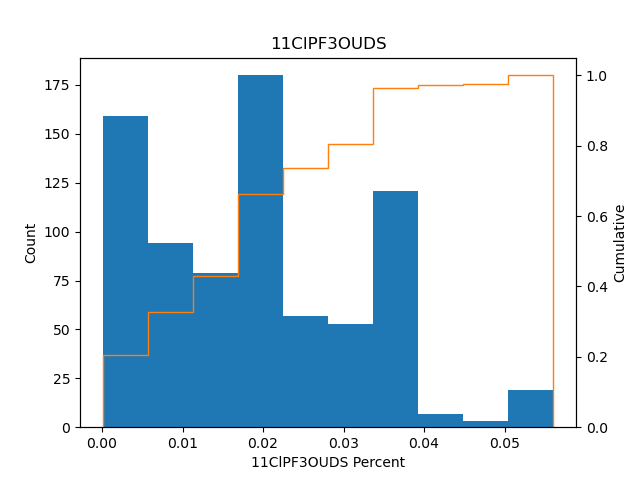

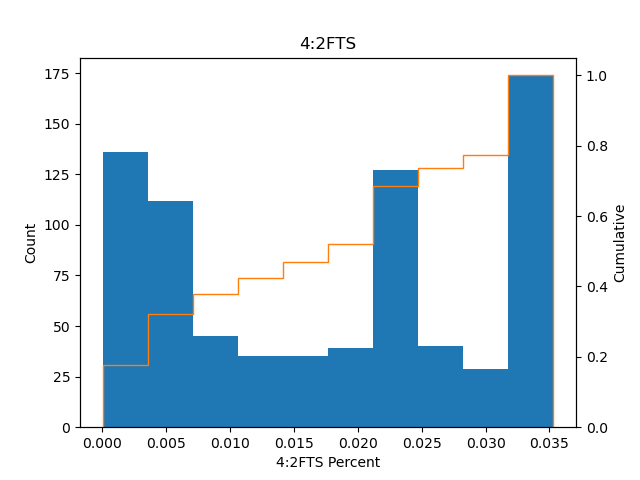

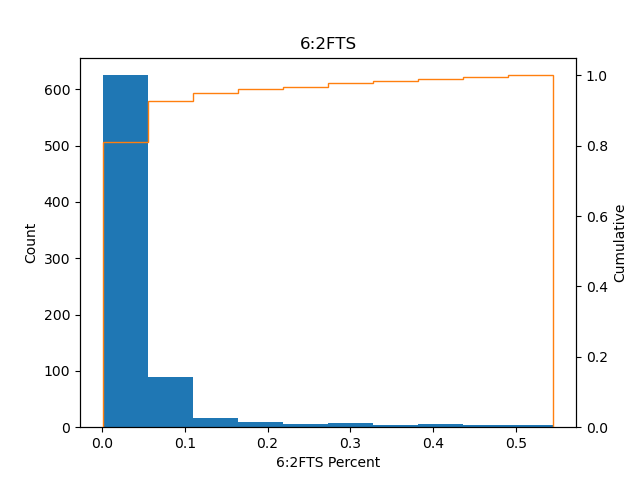

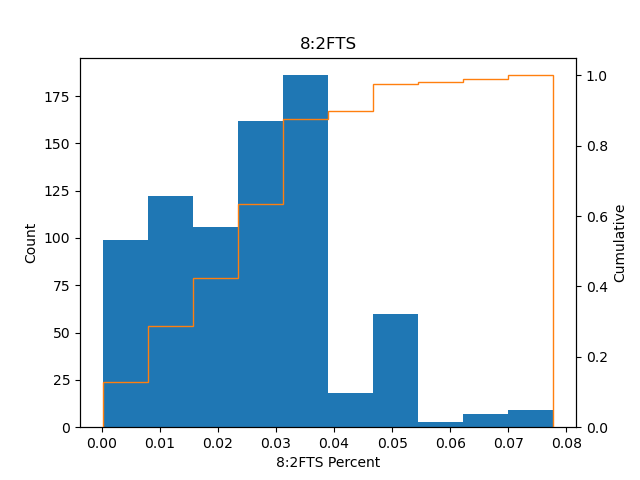

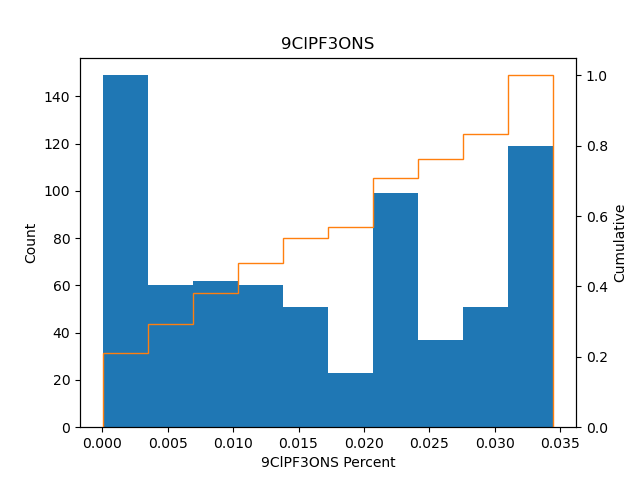

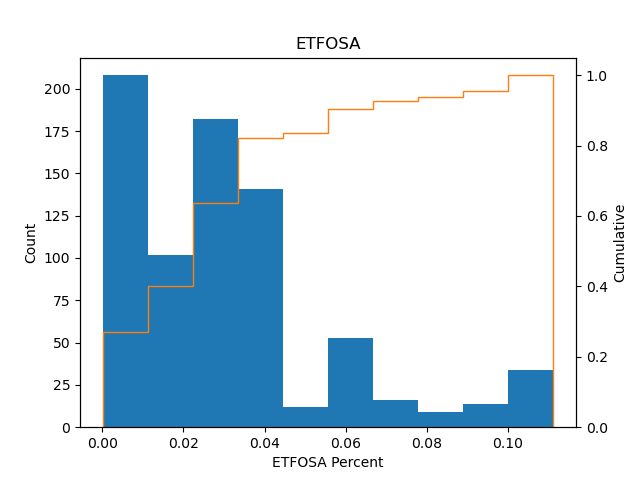

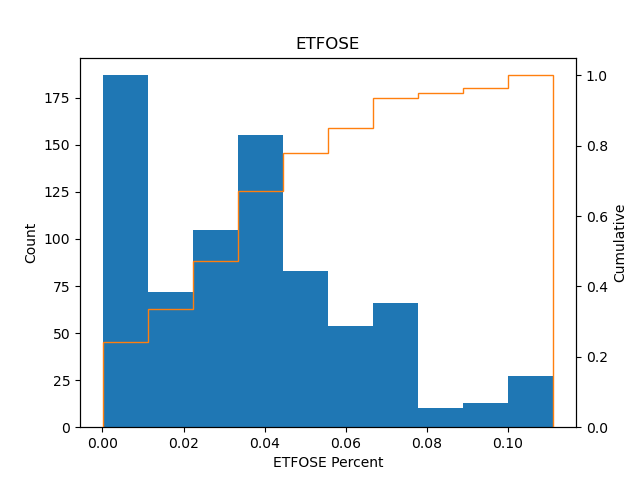

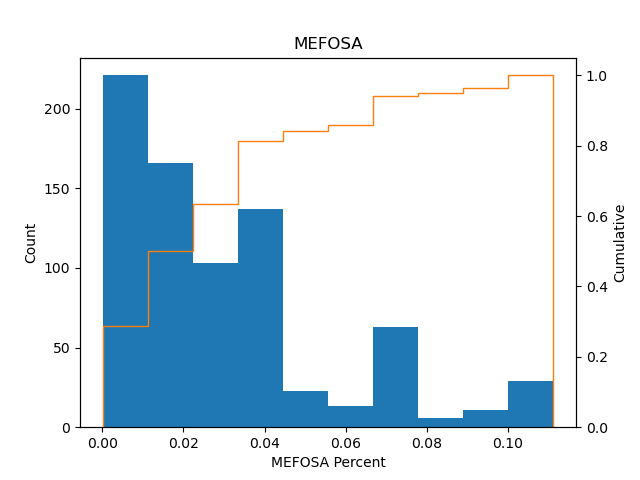

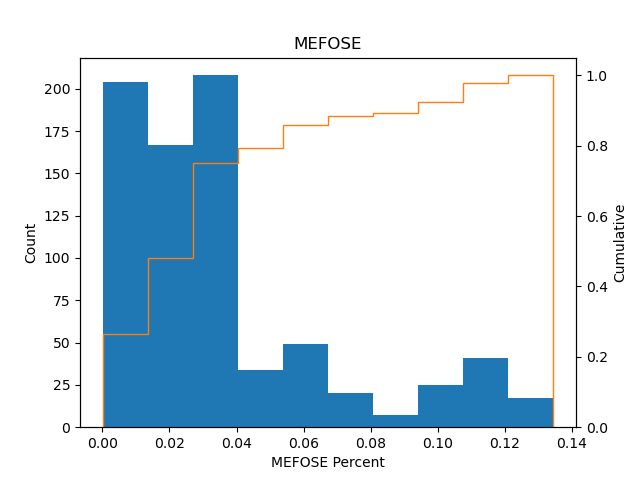

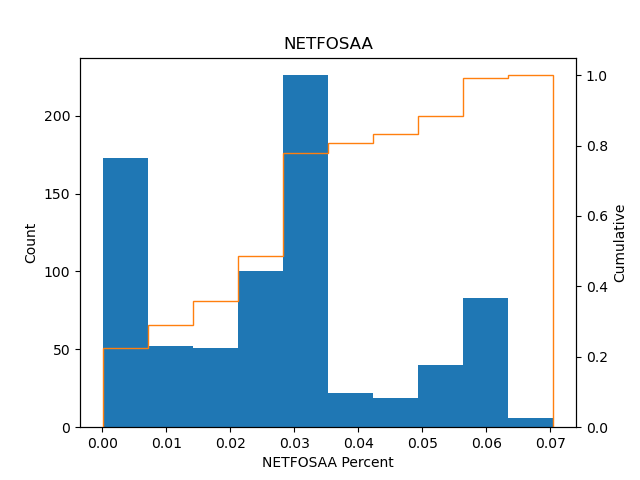

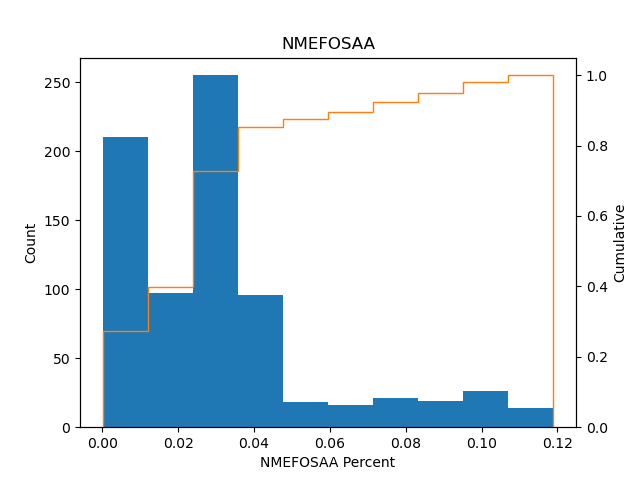

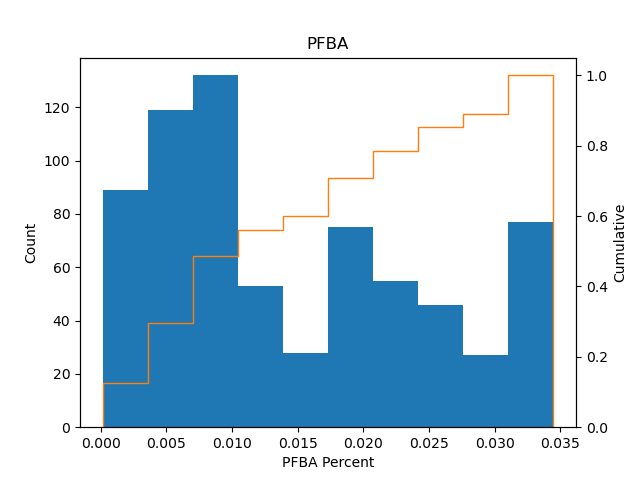

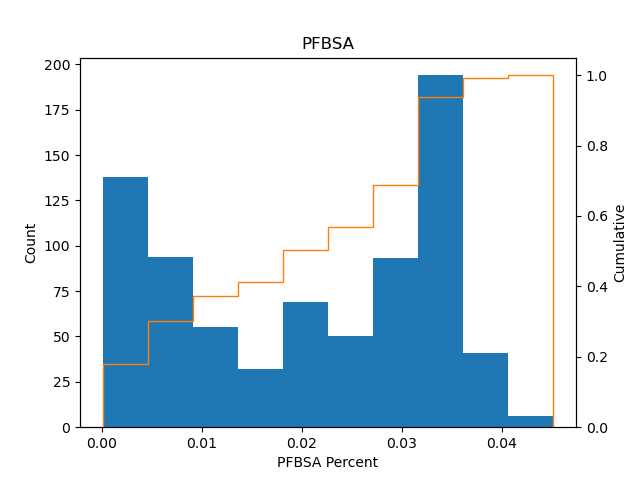

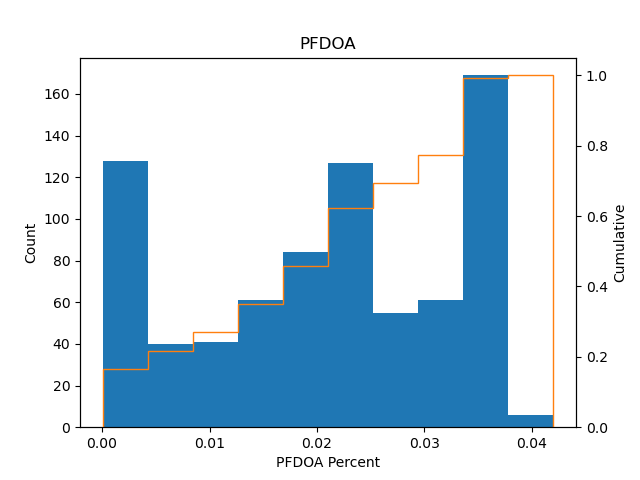

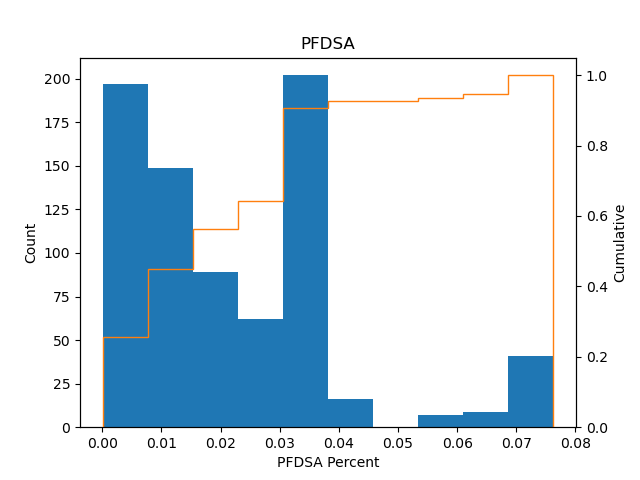

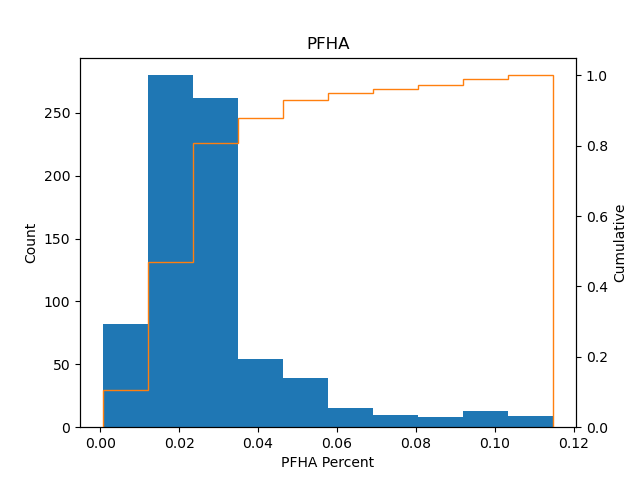

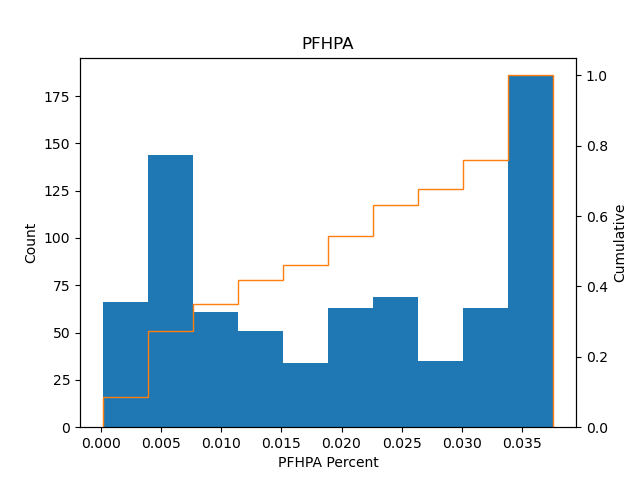

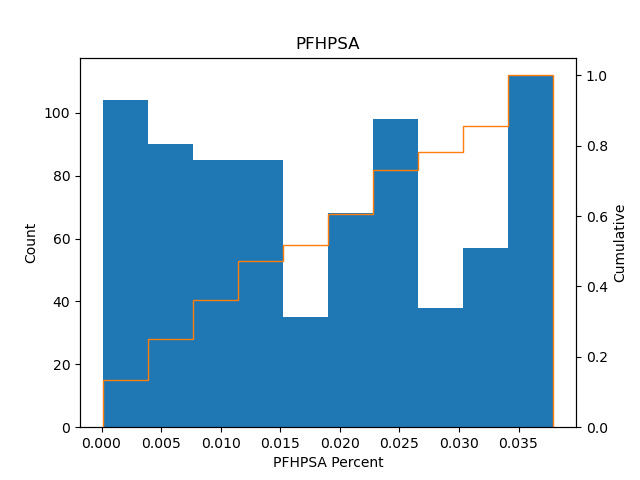

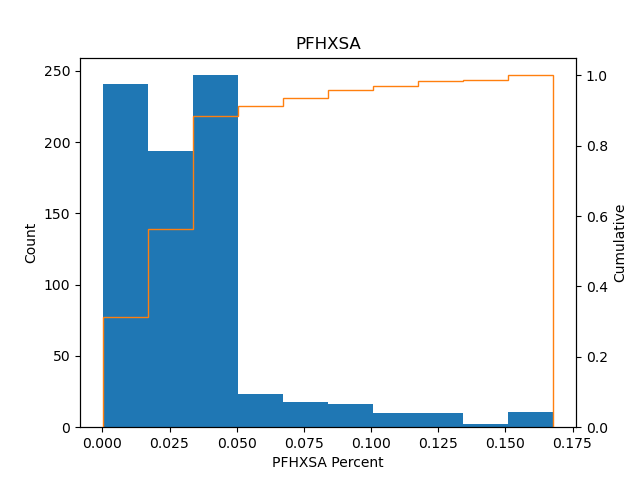

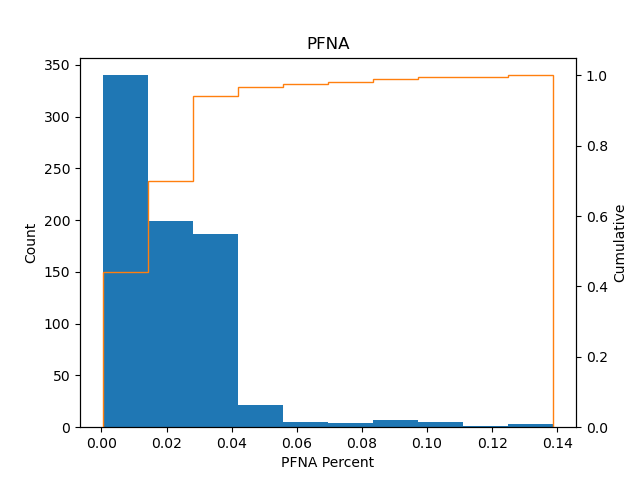

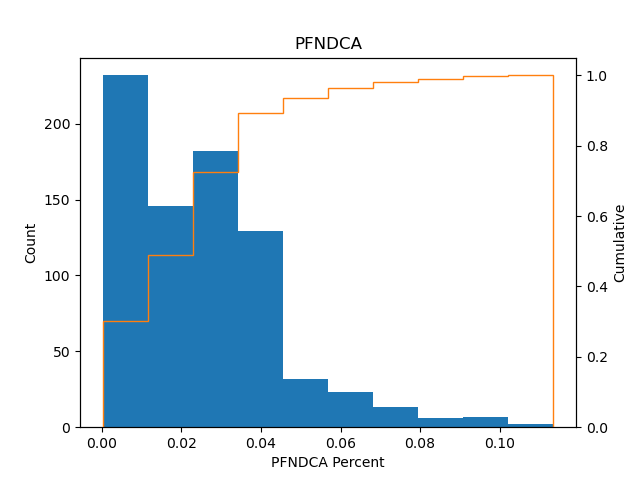

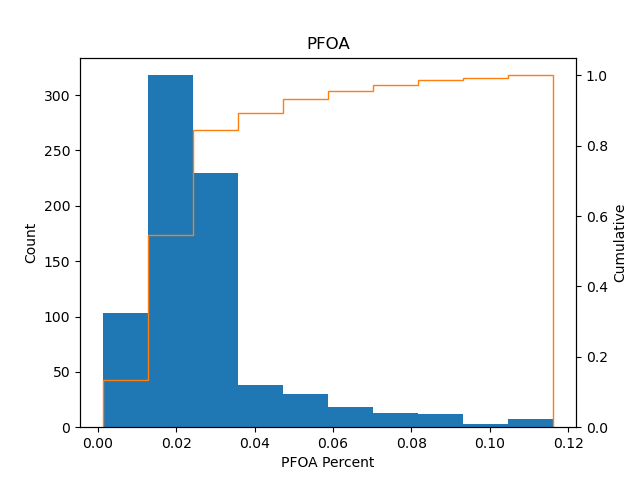

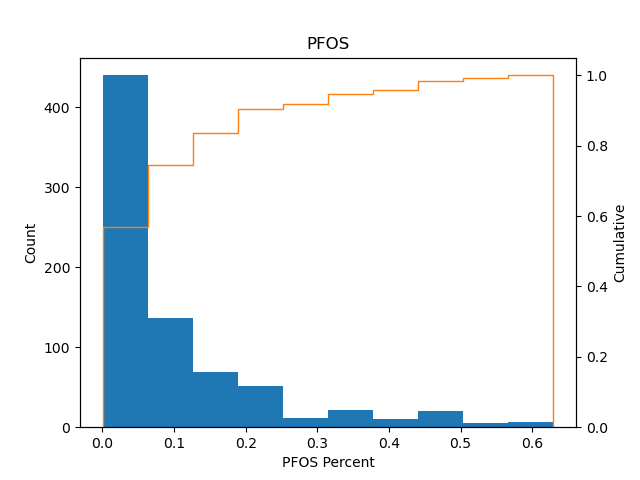

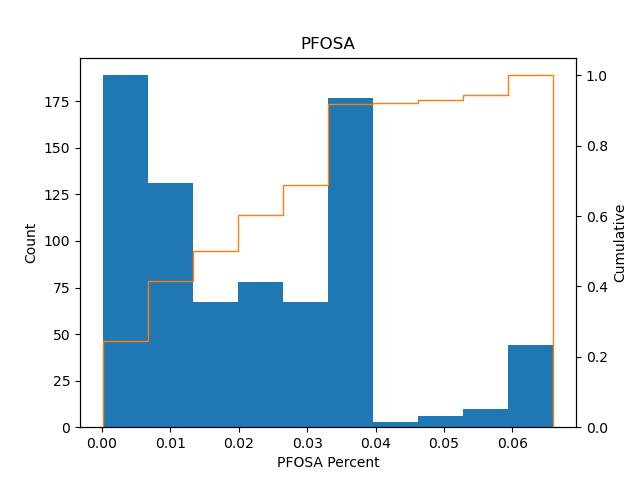

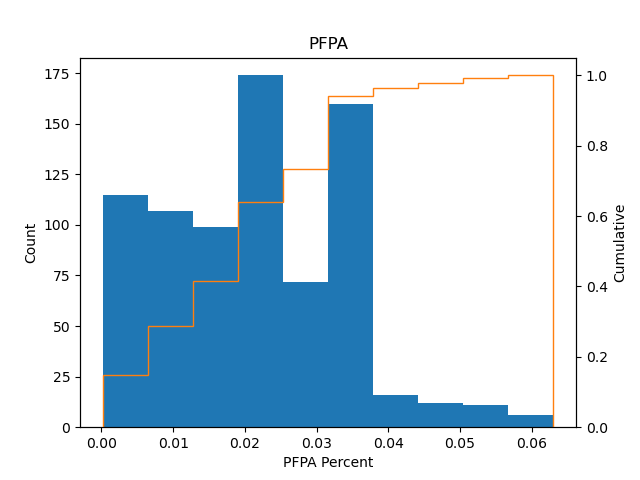

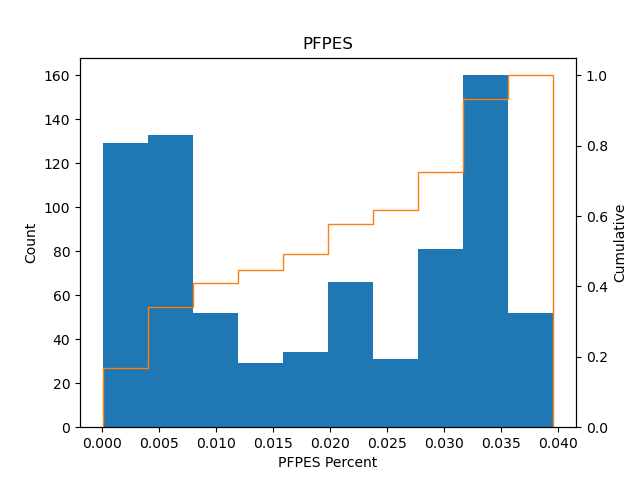

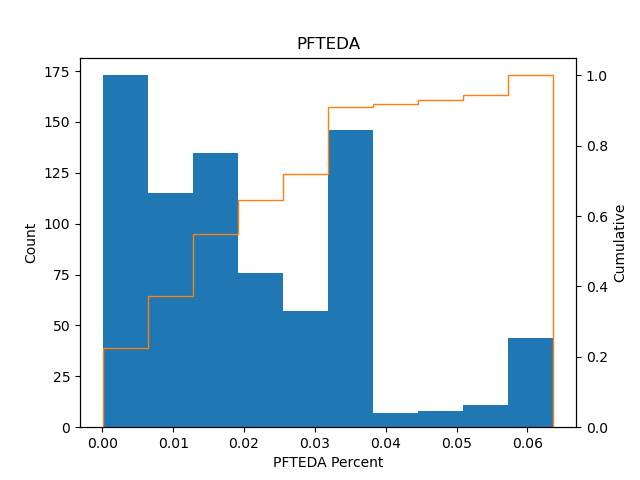

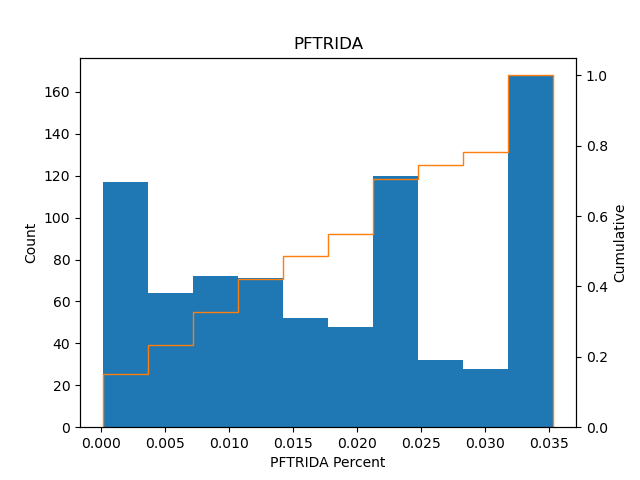

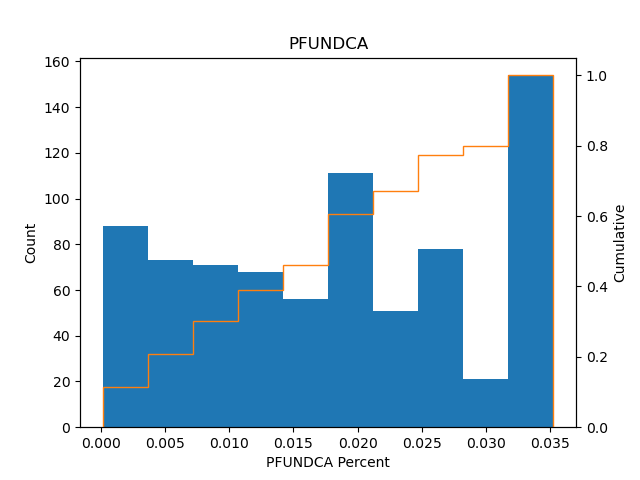

In [10]:
def pretty_graph(df, analyte):
    """takes a data frame and the name of a column containing numeric values. Makes a nice looking cumulative histogram"""
   
    # don't plot outliers, they tend to obscure the graph
    data = df[analyte][df[analyte] < df[analyte].quantile(.95)]
        
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_title(analyte)
    ax.set_xlabel('%s Percent' % analyte)
    ax.set_ylabel('Count')
    ax2.set_ylabel('Cumulative')
    n, bins, patches = ax.hist(data)
    n, bins, patches = ax2.hist(
        data, cumulative=1, histtype='step', color='tab:orange', density=True)
    
# make a cumulative histogram for each analyte
for analyte in dfp_clean.columns[len(idx_columns):]:
    pretty_graph(dfp_clean, analyte)


In [11]:
# get an idea of the max, min std and other statistical values for the data
display(dfp_clean.describe())

,Latitude,Longitude,11ClPF3OUDS,4:2FTS,6:2FTS,8:2FTS,9ClPF3ONS,ETFOSA,ETFOSE,MEFOSA,...,PFNA,PFNDCA,PFOA,PFOS,PFOSA,PFPA,PFPES,PFTEDA,PFTRIDA,PFUNDCA
count,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,...,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000
mean,35.170867,-118.950587,0.021331,0.019342,0.083903,0.037862,0.019535,0.035592,0.040671,0.034472,...,0.037250,0.031180,0.040198,0.138102,0.023894,0.026348,0.020619,0.023153,0.020706,0.022505
std,2.025924,1.779652,0.017313,0.014755,0.177719,0.072814,0.015730,0.034855,0.034160,0.034970,...,0.084064,0.034742,0.068893,0.187623,0.019359,0.028707,0.014633,0.019615,0.024620,0.030141
min,32.687260,-124.183936,0.000053,0.000033,0.000338,0.000090,0.000021,0.000059,0.000049,0.000066,...,0.000338,0.000156,0.001192,0.000090,0.000081,0.000149,0.000063,0.000018,0.000101,0.000149
25%,33.507220,-119.717890,0.008164,0.005750,0.016835,0.014288,0.006471,0.010665,0.013897,0.009930,...,0.010788,0.009001,0.018787,0.034483,0.007009,0.011912,0.006450,0.008361,0.008168,0.009437
50%,35.277154,-119.472638,0.019031,0.021425,0.032082,0.028508,0.021030,0.025570,0.034483,0.024793,...,0.019958,0.024178,0.023848,0.056625,0.022202,0.022034,0.022100,0.018973,0.020367,0.019639
75%,36.775259,-117.191620,0.032770,0.032741,0.053640,0.034483,0.031763,0.034483,0.058141,0.034483,...,0.034153,0.034483,0.034483,0.150179,0.034483,0.034072,0.034301,0.034483,0.032468,0.030388
max,41.744100,-114.596340,0.113636,0.130480,0.926476,0.815297,0.113636,0.182054,0.182054,0.182054,...,0.938848,0.237903,0.853730,0.975102,0.096742,0.333956,0.115820,0.167928,0.544364,0.594111


In [12]:
# Take a look at the analytes corralations
corr = dfp_clean[dfp_clean.columns[len(idx_columns):]].corr()
corr.style.background_gradient(cmap='coolwarm')

,11ClPF3OUDS,4:2FTS,6:2FTS,8:2FTS,9ClPF3ONS,ETFOSA,ETFOSE,MEFOSA,MEFOSE,NETFOSAA,NMEFOSAA,PFBA,PFBSA,PFDOA,PFDSA,PFHA,PFHPA,PFHPSA,PFHXSA,PFNA,PFNDCA,PFOA,PFOS,PFOSA,PFPA,PFPES,PFTEDA,PFTRIDA,PFUNDCA
11ClPF3OUDS,1.000000,0.665654,-0.290309,-0.073465,0.804723,0.307424,0.233234,0.350609,0.146955,0.169513,0.034492,0.359370,0.121303,0.443725,0.405607,-0.080343,0.259758,0.796772,-0.071731,-0.107276,0.081761,-0.138942,-0.383444,0.360468,0.072104,0.465919,0.324300,0.229299,0.081429
4:2FTS,0.665654,1.000000,-0.288862,-0.043722,0.668353,0.067875,0.097875,0.101893,0.087174,0.364043,0.122091,0.524495,0.168191,0.493439,0.475523,-0.092573,0.363280,0.743513,-0.066312,-0.132853,0.085418,-0.134955,-0.374283,0.508184,0.104578,0.577003,0.432271,0.240700,0.118008
6:2FTS,-0.290309,-0.288862,1.000000,-0.001323,-0.288561,-0.279150,-0.310832,-0.267362,-0.263763,-0.284035,-0.263814,-0.210556,-0.192372,-0.318126,-0.251587,0.062470,-0.049870,-0.359191,-0.153945,-0.054080,-0.237116,-0.092182,-0.166717,-0.254416,-0.030380,-0.309971,-0.169540,-0.127166,-0.145649
8:2FTS,-0.073465,-0.043722,-0.001323,1.000000,-0.096668,-0.155522,-0.177020,-0.140130,-0.151546,-0.106565,-0.144870,-0.091371,-0.090480,-0.074105,-0.095797,-0.109488,-0.094025,-0.105820,-0.094697,-0.060728,-0.091042,-0.097796,0.012961,-0.083483,-0.081410,-0.095193,-0.058814,0.029322,0.068947
9ClPF3ONS,0.804723,0.668353,-0.288561,-0.096668,1.000000,0.123947,0.234475,0.127541,0.044397,0.312189,0.088043,0.382993,0.180638,0.387268,0.653254,-0.115135,0.369280,0.727342,-0.066937,-0.161616,0.115089,-0.124787,-0.386954,0.548222,0.061617,0.623212,0.628147,0.193375,0.083794
ETFOSA,0.307424,0.067875,-0.279150,-0.155522,0.123947,1.000000,0.874173,0.978527,0.684896,0.133648,0.264331,-0.021386,-0.011213,0.267577,0.028422,-0.112021,-0.137374,0.225633,-0.244997,-0.170933,0.236405,-0.167820,-0.291406,0.014820,-0.112244,-0.003761,-0.019197,0.040538,-0.089850
ETFOSE,0.233234,0.097875,-0.310832,-0.177020,0.234475,0.874173,1.000000,0.835037,0.694587,0.363307,0.378584,-0.060321,0.093286,0.250085,0.350186,-0.137429,-0.050425,0.220299,-0.283125,-0.229687,0.232817,-0.201719,-0.355847,0.290711,-0.125450,0.141391,0.271478,0.021410,-0.112920
MEFOSA,0.350609,0.101893,-0.267362,-0.140130,0.127541,0.978527,0.835037,1.000000,0.661536,0.087408,0.209570,0.004970,-0.018265,0.246607,-0.011604,-0.113809,-0.130842,0.254923,-0.226365,-0.152178,0.192477,-0.164628,-0.287299,-0.016471,-0.095147,-0.000758,-0.058138,0.056617,-0.076803
MEFOSE,0.146955,0.087174,-0.263763,-0.151546,0.044397,0.684896,0.694587,0.661536,1.000000,0.386990,0.560707,0.012119,0.152747,0.230965,-0.056950,-0.044615,-0.273779,-0.002034,-0.281692,-0.181390,0.225743,-0.167868,-0.254084,-0.122709,-0.160754,-0.120965,-0.097017,-0.042768,-0.112342
NETFOSAA,0.169513,0.364043,-0.284035,-0.106565,0.312189,0.133648,0.363307,0.087408,0.386990,1.000000,0.730256,0.093896,0.232199,0.352820,0.441760,-0.093631,0.025250,0.186018,-0.224261,-0.203426,0.277959,-0.153890,-0.303903,0.401235,-0.078197,0.227757,0.385327,-0.006355,-0.057950


From the above graph there is a range of correlations from very highly correlated analytes to negatively correlated analytes. That likely indicates that there are patterns in the data that I can use to cluster it. Let's save the data and go try.

In [13]:
dfp_clean = dfp_clean.drop(columns = ['Units'])
dfp_clean.to_excel('cleaned_data.xlsx', index = False)